In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from joblib import parallel_backend
from project_functions.utils import picklify, unpickle
import pickle

In [2]:
# df = pd.read_parquet('../data/cleaned/tokenized_data_large_genres.parquet')

In [3]:
X_train_gensim_sparse = unpickle('../data/cleaned/X_train_gensim_sparse.pickle')
X_test_gensim_sparse = unpickle('../data/cleaned/X_test_gensim_sparse.pickle')
y_train = unpickle('../data/cleaned/y_train.pickle')
y_test = unpickle('../data/cleaned/y_test.pickle')

In [10]:
def run_model(X_train, X_test, y_train, y_test, model, model_params = None, grid_search = False,
              random_state = 42, scoring = make_scorer(accuracy_score), cv = 3,
              plot_confusion = False, display_report = False, pickle_ = False, pickle_dest = None):
    
    with parallel_backend('threading', n_jobs = -1):
        le = LabelEncoder()
        y_train_transformed = le.fit_transform(y_train)
        y_test_transformed = le.transform(y_test)
        
        if grid_search:
            classifier = GridSearchCV(estimator = model, param_grid = model_params,
                                 n_jobs = -1, scoring = scoring, cv = cv)
            if 'random_state' in classifier.get_params():
                classifier.set_params(**{'random_state': random_state})
        else:
            classifier = model
            if model_params is not None:
                classifier.set_params(**model_params)
            if 'random_state' in classifier.get_params():
                classifier.set_params(**{'random_state': random_state})
        
        classifier.fit(X_train, y_train_transformed)
                
        if any([plot_confusion, display_report]):
            y_pred = classifier.predict(X_test)
            y_score = classifier.score(X_test, y_test_transformed)
            print('Score: {}'.format(y_score))
        
        if plot_confusion:
            ConfusionMatrixDisplay(confusion_matrix(y_test_transformed, y_pred)).plot();
            
        if display_report:
            print(classification_report(y_test_transformed, y_pred))
            
        if pickle_:
            if pickle_dest is None:
                print('No pickle destination given, pickling skipped.')
            else:
                with open(pickle_dest, 'wb') as f:
                    pickle.dump(classifier, f)
        
    return classifier
    

Score: 0.5018181818181818
              precision    recall  f1-score   support

           0       0.33      0.36      0.35       911
           1       0.50      0.52      0.51       639
           2       0.75      0.73      0.74       840
           3       0.49      0.50      0.50      1014
           4       0.38      0.40      0.39       601
           5       0.63      0.58      0.60       969
           6       0.25      0.32      0.28       896
           7       0.82      0.47      0.60       690
           8       0.65      0.80      0.72       917
           9       0.43      0.33      0.37      1048

    accuracy                           0.50      8525
   macro avg       0.52      0.50      0.51      8525
weighted avg       0.52      0.50      0.50      8525



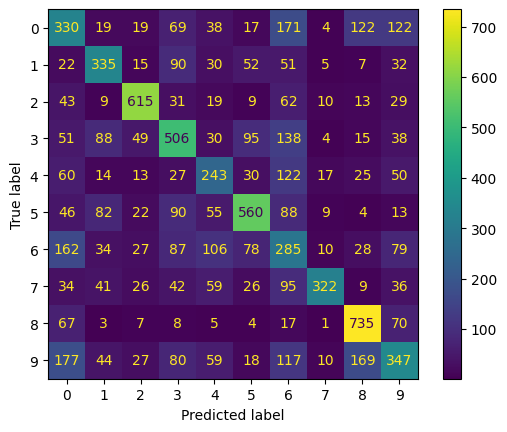

In [5]:
mnb_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
                       MultinomialNB(), plot_confusion = True, display_report = True)

Score: 0.49478005865102637
              precision    recall  f1-score   support

           0       0.31      0.41      0.35       911
           1       0.55      0.48      0.51       639
           2       0.70      0.71      0.70       840
           3       0.50      0.51      0.51      1014
           4       0.47      0.37      0.41       601
           5       0.53      0.61      0.57       969
           6       0.26      0.21      0.23       896
           7       0.79      0.51      0.62       690
           8       0.64      0.71      0.67       917
           9       0.39      0.40      0.39      1048

    accuracy                           0.49      8525
   macro avg       0.51      0.49      0.50      8525
weighted avg       0.50      0.49      0.49      8525



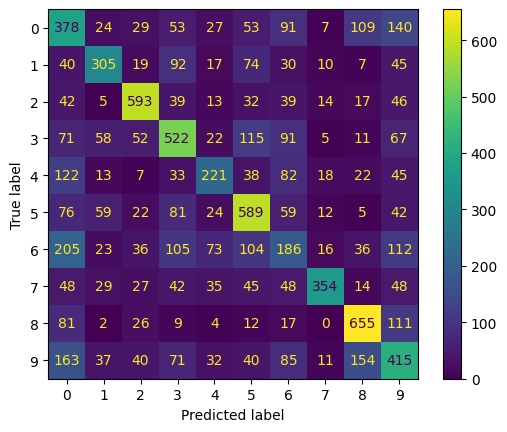

In [6]:
baseline_xg_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
                               XGBClassifier(), plot_confusion = True, display_report = True)

Score: 0.5246920821114369
              precision    recall  f1-score   support

           0       0.34      0.40      0.37       911
           1       0.56      0.50      0.53       639
           2       0.75      0.73      0.74       840
           3       0.53      0.55      0.54      1014
           4       0.49      0.47      0.48       601
           5       0.58      0.64      0.61       969
           6       0.28      0.26      0.27       896
           7       0.70      0.58      0.63       690
           8       0.70      0.73      0.71       917
           9       0.42      0.41      0.41      1048

    accuracy                           0.52      8525
   macro avg       0.53      0.53      0.53      8525
weighted avg       0.53      0.52      0.53      8525



KeyboardInterrupt: 

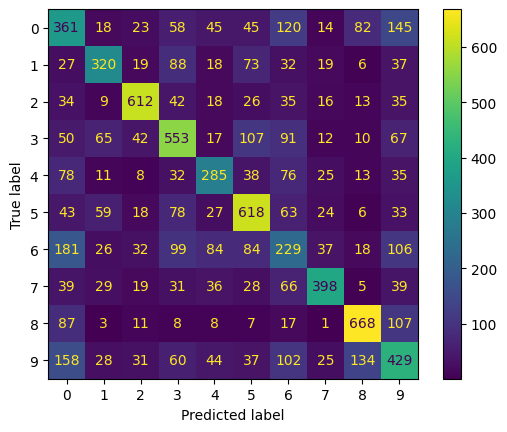

In [11]:
# %%timeit
# Tuning max depth and min child weight
params = {
    'n_estimators': [1000],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'alpha': [1],
    'gamma': [0]
}

pickle_dest = '../data/cleaned/max_depth_min_child_xgboost_gensim.pickle'

xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
                                        XGBClassifier(), grid_search = True, scoring = None,
                                        model_params = params, plot_confusion = True, display_report = True,
                                        pickle_ = True, pickle_dest = pickle_dest)

In [18]:
# %%timeit
# Tuning gamma
params = {
    'n_estimators': [1000],
    'max_depth': [3],
    'min_child_weight': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'alpha': [1],
    'gamma': [i / 10.0 for i in range(0, 6)]
}

pickle_dest = '../data/cleaned/gamma_xgboost_gensim.pickle'

xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
                                        XGBClassifier(), grid_search = True, scoring = None,
                                        model_params = params, display_report = True,
                                        pickle_ = True, pickle_dest = pickle_dest)

Score: 0.5189442815249267
              precision    recall  f1-score   support

           0       0.33      0.38      0.35       911
           1       0.57      0.51      0.54       639
           2       0.75      0.72      0.74       840
           3       0.52      0.53      0.52      1014
           4       0.46      0.47      0.47       601
           5       0.57      0.63      0.60       969
           6       0.27      0.25      0.26       896
           7       0.72      0.57      0.64       690
           8       0.68      0.73      0.71       917
           9       0.42      0.41      0.42      1048

    accuracy                           0.52      8525
   macro avg       0.53      0.52      0.52      8525
weighted avg       0.52      0.52      0.52      8525



In [21]:
# %%timeit
# Tuning subsampling
params = {
    'n_estimators': [1000],
    'max_depth': [3],
    'min_child_weight': [1],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'alpha': [1],
    'gamma': [0.1]
}

pickle_dest = '../data/cleaned/subsample_colsample_xgboost_gensim.pickle'

xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
                                        XGBClassifier(), grid_search = True, scoring = None,
                                        model_params = params, display_report = True,
                                        pickle_ = True, pickle_dest = pickle_dest)

Score: 0.5248093841642228
              precision    recall  f1-score   support

           0       0.34      0.41      0.38       911
           1       0.57      0.51      0.54       639
           2       0.76      0.73      0.74       840
           3       0.52      0.54      0.53      1014
           4       0.50      0.47      0.48       601
           5       0.59      0.64      0.61       969
           6       0.27      0.24      0.26       896
           7       0.72      0.58      0.64       690
           8       0.69      0.73      0.71       917
           9       0.41      0.42      0.41      1048

    accuracy                           0.52      8525
   macro avg       0.54      0.53      0.53      8525
weighted avg       0.53      0.52      0.53      8525



In [24]:
# %%timeit
# Tuning subsampling further
params = {
    'n_estimators': [1000],
    'max_depth': [3],
    'min_child_weight': [1],
    'subsample':[0.9, 0.95, 1],
    'colsample_bytree':[0.9, 0.95, 1],
    'alpha': [1],
    'gamma': [0.1]
}

pickle_dest = '../data/cleaned/subsample_colsample_higher_xgboost_gensim.pickle'

xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
                                        XGBClassifier(), grid_search = True, scoring = None,
                                        model_params = params, display_report = True,
                                        pickle_ = True, pickle_dest = pickle_dest)

Score: 0.5229325513196481
              precision    recall  f1-score   support

           0       0.33      0.42      0.37       911
           1       0.57      0.50      0.53       639
           2       0.75      0.73      0.74       840
           3       0.52      0.55      0.53      1014
           4       0.48      0.45      0.46       601
           5       0.57      0.64      0.60       969
           6       0.28      0.24      0.26       896
           7       0.73      0.58      0.65       690
           8       0.68      0.73      0.70       917
           9       0.42      0.40      0.41      1048

    accuracy                           0.52      8525
   macro avg       0.53      0.52      0.53      8525
weighted avg       0.53      0.52      0.52      8525



In [ ]:
# %%timeit
# Best Params
params = {
    'n_estimators': [1000],
    'max_depth': [3],
    'min_child_weight': [1],
    'subsample':[1],
    'colsample_bytree':[1],
    'alpha': [1],
    'gamma': [0.1]
}

pickle_dest = '../data/cleaned/subsample_colsample_higher_xgboost_gensim.pickle'

xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
                                        XGBClassifier(), grid_search = True, scoring = None,
                                        model_params = params, display_report = True,
                                        pickle_ = True, pickle_dest = pickle_dest)